## IMDB review sentiment Analysis


#### Μέλη Ομάδας:
- Ευάγγελος Λευτάκης : 3200093
- Ρέα Σκλήκα : 3210181
- Σοφία-Ζωή Σωτηρίου : 3210192

### Dependencies

In [ ]:
# %pip install -U pandas
# %pip install -U numpy
# %pip install -U scipy
# %pip install -U tensorflow
# %pip install -U scikit-learn
# %pip install -U pydot
# %pip install -U seaborn

In [4]:
import pandas as pd
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import sklearn
import tensorflow as tf
from math import log
from sklearn.metrics import accuracy_score,precision_score, recall_score, f1_score,  classification_report
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, SimpleRNN, Dense, Flatten, Reshape, Dropout
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import plot_model
from tensorflow.keras.regularizers import l2
from sklearn.linear_model import LogisticRegression as skLogReg
from sklearn.naive_bayes import BernoulliNB
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import learning_curve
from IPython.display import display
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import classification_report
from sklearn import tree
from sklearn.metrics import roc_curve as skroc_curve
from sklearn.metrics import roc_auc_score, precision_recall_curve
from scipy.special  import expit, logsumexp
import os 
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1'
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
%matplotlib inline

### Part 1

#### Data Preperation
First We Prepare the train and test data and create a binary representation of it.

In [5]:
(x_train_imdb, y_train), (x_test_imdb, y_test) = tf.keras.datasets.imdb.load_data()


word_index = tf.keras.datasets.imdb.get_word_index()
index2word = dict((i + 3, word) for (word, i) in word_index.items())
index2word[0] = '[pad]'
index2word[1] = '[bos]'
index2word[2] = '[oov]'
x_train_imdb = np.array([' '.join([index2word[idx] for idx in text]) for text in x_train_imdb])
x_test_imdb = np.array([' '.join([index2word[idx] for idx in text]) for text in x_test_imdb])

binary_vectorizer = CountVectorizer(binary=True, min_df=100,stop_words="english")
x_train = binary_vectorizer.fit_transform(x_train_imdb)
x_test = binary_vectorizer.transform(x_test_imdb)
print(
    'Vocabulary size:', len(binary_vectorizer.vocabulary_)
)
x_train = x_train.astype(int)
x_test = x_test.astype(int)

x_train = x_train.toarray()
x_test = x_test.toarray()



Vocabulary size: 3563


#### Diagrams and results 
Implementation of Learning curves for train and validation scores as well as precision, recall and f1 diagrams with corresponding result tables.

In [32]:
def my_learning_curve(estimator, X, y  ,train_sizes, scoring, title, cv=5):
    train_sizes, train_scores, validation_scores = learning_curve(
    estimator = estimator,
    X = X,
    y = y, 
    train_sizes = train_sizes,
    cv=cv,
    scoring = scoring)
    train_scores_mean = train_scores.mean(axis = 1)
    validation_scores_mean = validation_scores.mean(axis = 1)
    plt.plot(train_sizes,  train_scores_mean, label = 'Training accuracy')
    plt.plot(train_sizes,  validation_scores_mean, label = 'Validation accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Training set size')
    plt.title(title, y = 1.03)
    plt.legend()
    plt.show()

    learning_curve_df = pd.DataFrame({
        'Training Set Size': train_sizes,
        'Training Accuracy': train_scores_mean,
        'Validation Accuracy': validation_scores_mean
    })
    learning_curve_df.set_index('Training Set Size', drop=True, inplace=True)
    # Printing the table
    print("\nLearning Curve Data:")
    display(learning_curve_df)

    
def custom_classification_report(estimator,x_train, y_train,x_test, y_test, train_sizes,name):
    classification_diagrams(estimator,x_train, y_train,x_test, y_test, train_sizes, name)
    my_learning_curve(estimator = estimator, X = x_train, y = y_train,  train_sizes = [1000,5000,10000,15000,20000], scoring = 'accuracy',title=name+" Learning Curve")

def classification_diagrams(estimator,x_train, y_train,x_test, y_test, train_sizes, name):
    precisions = np.array([])
    recalls = np.array([])
    f1 = np.array([])
    
    for size in train_sizes:
        x_train_temp, y_train_temp = x_train[:size], y_train[:size]
        estimator.fit(x_train_temp,y_train_temp)
        y_predicted = estimator.predict(x_test)
        precision = precision_score(y_test, y_predicted)
        recall = recall_score(y_test, y_predicted)
        f1_res = f1_score(y_test, y_predicted)
        #if verbose:
        #print(classification_report(y_test, y_predicted))
        precisions = np.append(precisions, precision)
        recalls = np.append(recalls, recall)
        f1 = np.append(f1, f1_res)

    fig, (ax1, ax2, ax3) = plt.subplots(3)
    fig.suptitle(name+' Results')

    ax1.plot(train_sizes, precisions,label='Precision', color='blue')
    ax1.legend()

    ax2.plot(train_sizes, recalls,label='Recall', color='red')
    ax2.legend()
    
    ax3.plot(train_sizes, f1, label='f1-score', color='green')
    ax3.legend()
    
    plt.show()


    results_df = pd.DataFrame({
    'Training Set Size': train_sizes,
    'Precision': precisions,
    'Recall': recalls,
    'F1-Score': f1
    })
    results_df.set_index('Training Set Size', drop=True, inplace=True)
    # Printing the table
    print(name+" Results:")
    display(results_df)
    


#### Logistic Regression:


In [33]:
class LogisticRegression():
   

    def __init__(self,epochs=20,learning_rate=0.001,threshold=0.5, regularization_factor=1):
        self.epochs=epochs;
        self.learning_rate=learning_rate
        self.weights = np.array([])
        self.threshold=threshold
        self.regularization_factor = regularization_factor
        
    
    def set_threshold(self,value):
        self.threshold = value
    def get_threshold(self):
        return self.threshold
    def sigmoid(self , t):
        return 1/(1+np.exp(-t))


    def fit(self,x_train_input,y_train_input):
        ''' '''
        feature_vector_length = x_train_input.shape[1]
        split_index = int(0.8 * x_train_input.shape[0])  # 80% for training, 20% for dev
        x_train, y_train = x_train_input[:split_index], y_train_input[:split_index]
        x_dev, y_dev= x_train_input[split_index:], y_train_input[split_index:]

        # We prepare the array by adding a column of 1s
        # for the w0 weight
        ones_column = np.ones(x_train.shape[0])
        x_train = np.insert(x_train, 0, ones_column, axis=1)
        self.weights = self.initialize_weights(feature_vector_length)
        
        for epoch in range(self.epochs):
            suffled_indices = np.random.permutation(x_train.shape[0])
            x_train_shuffled = x_train[suffled_indices]
            y_train_shuffled = y_train[suffled_indices]
            for i in range(x_train.shape[0]):
                x_i = x_train_shuffled[i-1]
                y_i = y_train_shuffled[i-1]

                self.update_weights(x_i,y_i)
        x_train = np.delete(x_train, 0, axis=1)                 #remove 1s column again (needed previously for w0)

        return self.evaluate(y_train,self.predict(x_train))


        
    
    def predict(self, x_test):
        ones_column = np.ones(x_test.shape[0])
        x_test = np.insert(x_test, 0, ones_column, axis=1)#insert 1 in x_vector for w0

        y_test_predicted = []

        for test_case in x_test:
            probability_positive =  self.sigmoid(np.dot(self.weights,test_case))
            predicted_class = 1 if probability_positive >= self.threshold else 0
            y_test_predicted.append(predicted_class)

        x_test = np.delete(x_test, 0, axis=1)
        return np.array(y_test_predicted)

    def predict_proba(self, x_test):
        ones_column = np.ones(x_test.shape[0])
        x_test = np.insert(x_test, 0, ones_column, axis=1)#insert 1 in x_vector for w0

        y_test_predicted = []

        for test_case in x_test:
            probability_positive =  self.sigmoid(np.dot(self.weights,test_case))
            y_test_predicted.append([probability_positive,(1-probability_positive)])
        x_test = np.delete(x_test, 0, axis=1)
        return np.array(y_test_predicted)
    
    def get_params(self, deep=True):
        return {
            'epochs': self.epochs,
            'learning_rate': self.learning_rate,
            'threshold': self.threshold,
            'regularization_factor': self.regularization_factor
        }


    @staticmethod
    def initialize_weights(size):
        '''We Initialize the weights with random values with a mean of 0 and a standard deviation of 0.01
          This is a common practice to prevent the weights from being too large at the begining '''
        return np.random.randn(size+1) * 0.01

    def update_weights(self,x_test,y_test):
        predicted_prob = self.sigmoid(np.dot(self.weights,x_test))
        gradient = ((y_test - predicted_prob) * x_test)
        self.weights = (1 - 2*self.regularization_factor*self.learning_rate) * self.weights + self.learning_rate * gradient 
    
    def evaluate(self, y_true, y_predicted, verbose=False):
        precision = precision_score(y_true, y_predicted)
        recall = recall_score(y_true, y_predicted)
        f1 = f1_score(y_true, y_predicted)
        if verbose:
            print(classification_report(y_true, y_predicted))
            print("Threshold: "+str(self.threshold))
        return np.array([precision,recall,f1])

##### Results
Here we try out the Logistic Regression learning algorithm

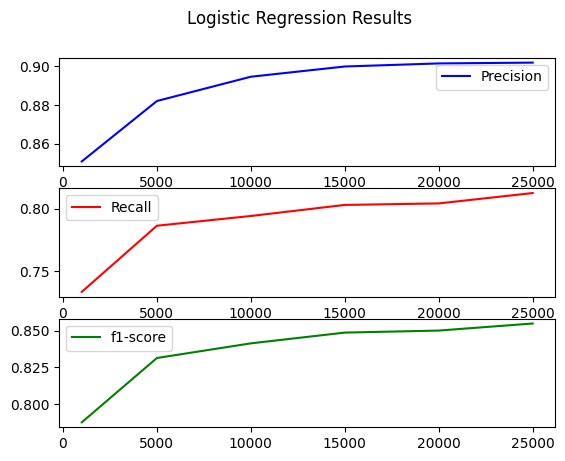

Logistic Regression Results:


,Precision,Recall,F1-Score
Training Set Size,,,
1000,0.850742,0.73368,0.787887
5000,0.881999,0.78632,0.831416
10000,0.894557,0.79408,0.841329
15000,0.899848,0.80288,0.848603
20000,0.901435,0.80408,0.849979
25000,0.901856,0.81232,0.854750


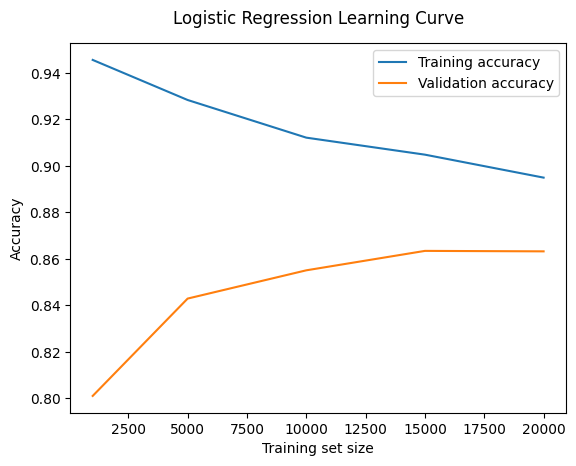


Learning Curve Data:


,Training Accuracy,Validation Accuracy
Training Set Size,,
1000,0.94560,0.80104
5000,0.92836,0.84292
10000,0.91216,0.85508
15000,0.90484,0.86344
20000,0.89496,0.86324


In [34]:
LogReg = LogisticRegression(100,threshold=0.6, regularization_factor=0.001)
custom_classification_report(estimator=LogReg,x_train=x_train,y_train=y_train,x_test=x_test, y_test=y_test, train_sizes = [1000,5000,10000,15000,20000,25000],name='Logistic Regression')

#### Naive Bayes:

In [7]:
class NaiveBayes: 
    def __init__(self,alpha=1):
            '''
            probabilityC0 = 1 -probabilityC1
            '''
            self.probabilityC1= None 
            self.boundProbabilityC0 = None 
            self.boundProbabilityC1 = None
            self.alpha = alpha

    def fit(self, x_train_input, y_train_input): 
        split_index = int(0.8 * x_train_input.shape[0])  
        x_train, y_train = x_train_input[:split_index], y_train_input[:split_index]
        x_dev, y_dev= x_train_input[split_index:], y_train_input[split_index:]
        
        numberOfExamples = x_train.shape[0]
        numberOfFeatures = x_train.shape[1]
        '''
        negativeReviews = 1 - positiveReviews
        '''
        positiveReviews = 0
        positiveReviews = np.sum(y_train)
        self.probabilityC1 = positiveReviews / numberOfExamples

        '''
        C0: P( X(i) = 0 | C = 0) and C1 = P ( X(i) = 0 | C = 1)
        P( X(i) = 1 | C = 0) = 1 - P( X(i) = 0 | C = 0) and P( X(i) = 1 | C = 1) = P( X(i) = 0 | C = 1)
        '''
        self.boundProbabilityC0 = np.ones(numberOfFeatures) * self.alpha
        self.boundProbabilityC1 = np.ones(numberOfFeatures) * self.alpha
        for i in range(numberOfFeatures): 
            '''
            For every word that is not on a review add to the array correspnding to the review result of the example
            '''
            for j in range(numberOfExamples):  
                if y_train[j] == 0 and x_train[j][i] == 0: 
                    self.boundProbabilityC0[i] += 1 
                elif y_train[j] == 1 and x_train[j][i] == 0: 
                    self.boundProbabilityC1[i] += 1 
        """
        Adding Laplace estimator with an alpha value of 1
        """
        self.boundProbabilityC0 = [(x + self.alpha) / (numberOfExamples - positiveReviews + 2 * self.alpha) for x in self.boundProbabilityC0]
        self.boundProbabilityC1 = [(x + self.alpha) / (positiveReviews + 2 * self.alpha) for x in self.boundProbabilityC1]


    def get_params(self, deep=True):
        return {'alpha': self.alpha}

    def predict(self, x_test):
        prediction = list()
        numberOfFeatures = x_test.shape[1]

        for x in x_test:
            positiveReviewProbability = log(self.probabilityC1)
            negativeReviewProbability = log(1 - self.probabilityC1)
            for y in range(numberOfFeatures): 
                if x[y] == 1:
                    positiveReviewProbability += log(max(1e-10, 1 - self.boundProbabilityC1[y]))
                    negativeReviewProbability += log(max(1e-10, 1 - self.boundProbabilityC0[y]))
                elif x[y] == 0: 
                    positiveReviewProbability += log(self.boundProbabilityC1[y])
                    negativeReviewProbability += log(self.boundProbabilityC0[y])
            if positiveReviewProbability > negativeReviewProbability: 
                prob = 1
            elif negativeReviewProbability > positiveReviewProbability: 
                prob = 0

            prediction.append(prob)

        return np.array(prediction)
    
    def predict_proba(self, x_test):
        prediction = list()
        numberOfFeatures = x_test.shape[1]
        for x in x_test:
            positiveReviewProbability = log(self.probabilityC1)
            negativeReviewProbability = log(1 - self.probabilityC1)
            for y in range(numberOfFeatures): 
                if x[y] == 1:
                    positiveReviewProbability += log(max(1e-10, 1 - self.boundProbabilityC1[y]))
                    negativeReviewProbability += log(max(1e-10, 1 - self.boundProbabilityC0[y]))
                elif x[y] == 0: 
                    positiveReviewProbability += log(self.boundProbabilityC1[y])
                    negativeReviewProbability += log(self.boundProbabilityC0[y])
            
            log_probabilities = [positiveReviewProbability, negativeReviewProbability]

            '''Normalize using logsumexp'''
            log_normalization = logsumexp(log_probabilities)

            '''Calculate normalized probabilities'''
            prob_positive = np.exp(positiveReviewProbability - log_normalization)

            prediction.append([prob_positive, 1-prob_positive])
            
        return np.array(prediction)
    
    def evaluate(self, y_true, y_predicted, verbose=False):
        precision = precision_score(y_true, y_predicted)
        recall = recall_score(y_true, y_predicted)
        f1 = f1_score(y_true, y_predicted)
        if verbose:
            print(classification_report(y_true, y_predicted))
        return np.array([precision,recall,f1])

    def classification_diagrams(self,x_train, y_train,x_test, y_test, train_sizes):
        precisions = np.array([])
        recalls = np.array([])
        f1 = np.array([])
        
        for size in train_sizes:
            x_train_temp, y_train_temp = x_train[:size], y_train[:size]
            self.fit(x_train_temp,y_train_temp)
            y_predicted = self.predict(x_test)
            evaluation = self.evaluate(y_test,y_predicted,verbose=False)
            precisions = np.append(precisions, evaluation[0])
            recalls = np.append(recalls, evaluation[1])
            f1 = np.append(f1, evaluation[2])

        fig, (ax1, ax2, ax3) = plt.subplots(3)
        fig.suptitle('Naive Bayes Results')

        ax1.plot(train_sizes, precisions,label='Precision', color='blue')
        ax1.legend()

        ax2.plot(train_sizes, recalls,label='Recall', color='red')
        ax2.legend()
        
        ax3.plot(train_sizes, f1, label='f1-score', color='green')
        ax3.legend()
        
        plt.show()


        results_df = pd.DataFrame({
        'Training Set Size': train_sizes,
        'Precision': precisions,
        'Recall': recalls,
        'F1-Score': f1
        })
        results_df.set_index('Training Set Size', drop=True, inplace=True)
        # Printing the table
        print("\nNaive Bayes Results:")
        display(results_df)
    
    def custom_classification_report(self,x_train, y_train,x_test, y_test, train_sizes):
        self.classification_diagrams(x_train, y_train,x_test, y_test, train_sizes)
        my_learning_curve(estimator = self, X = x_train, y = y_train,  train_sizes = [1000,5000,10000,15000,20000], scoring = 'accuracy',title="Naive Bayes Learning Curve")

    



##### Results:

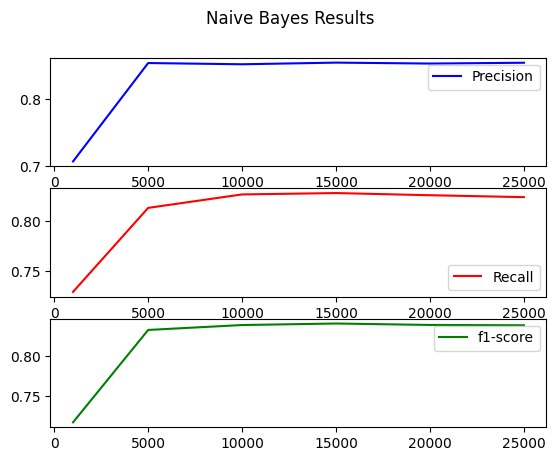

Naive Bayes Results:


,Precision,Recall,F1-Score
Training Set Size,,,
1000,0.706827,0.72888,0.717684
5000,0.853280,0.81280,0.832548
10000,0.851443,0.82624,0.838652
15000,0.853900,0.82760,0.840544
20000,0.852516,0.82544,0.838760
25000,0.853707,0.82352,0.838342


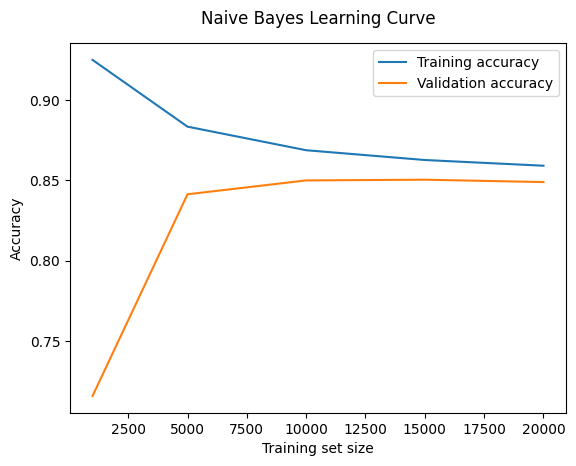


Learning Curve Data:


,Training Accuracy,Validation Accuracy
Training Set Size,,
1000,0.924800,0.71576
5000,0.883280,0.84120
10000,0.868620,0.84984
15000,0.862533,0.85028
20000,0.858980,0.84880


In [35]:
NB = NaiveBayes()
custom_classification_report(estimator=NB,x_train=x_train,y_train=y_train,x_test=x_test, y_test=y_test, train_sizes = [1000,5000,10000,15000,20000,25000],name='Naive Bayes')


#### [AdaBoost:](Machine-Learning-Algorithms/AdaBoost.py)

In [46]:
class AdaBoost:
    def __init__(self,amount_of_says=None, models = None):
        self.models = models if models is not None else []
        self.weights = []
        self.amount_of_says = amount_of_says if amount_of_says is not None else []
    
    def get_params(self, deep=True):
        return {'amount_of_says': self.amount_of_says,
                'models': self.models,
                }

    def fit (self, x_train_input, y_train_input, M):
        split_index = int(0.8 * x_train_input.shape[0])  # 80% for training, 20% for dev
        x_train, y_train = x_train_input[:split_index], y_train_input[:split_index]
        x_dev, y_dev= x_train_input[split_index:], y_train_input[split_index:]

        y_train = 2 * y_train - 1
        y_dev = 2 * y_dev - 1
        # initializing weights equally
        self.weights = np.ones(x_train.shape[0]) / x_train.shape[0]
        m = 0 
        epsilon = 1e-10        # Small epsilon value to avoid division by zero
        while m < M:
            # create the base learner (decision stumps)
            stump = tree.DecisionTreeClassifier(max_depth=1)
            stump = stump.fit(x_train,y_train,self.weights)
            y_pred = stump.predict(x_train)
            error = self.calculate_error(y_train, y_pred, self.weights)
            alpha =1/2 *np.log((1-error)/(error+epsilon))
            self.change_weights(y_pred, y_train, alpha)
            x_train, y_train = self.updateData(x_train, y_train)
            if error >= 0.5:
                m -= 1
            else:
                self.models.append(stump)
                self.amount_of_says.append(alpha)
                m +=1
        y_dev_predicted = self.predict(x_dev)
        return self.evaluate(y_dev,y_dev_predicted)

    def calculate_error(self, y, y_pred, w):
        return (sum(w*(np.not_equal(y, y_pred)).astype(int)))
    '''
    make a new empty dataset the same size as the original and pick a random number [0..1)
    and see where that number falls when the sample weights are used like a distribution
    fill the new dataset with those values 
    '''
    def updateData(self, x, y):
        distribution = np.cumsum(self.weights)
        newDataset = np.zeros_like(x)
        temp_y = np.zeros_like(y)
        for i in range (x.shape[0]):
            number = np.random.rand()
            index = np.searchsorted(distribution, number)
            newDataset[i, :] = x[index, :]
            temp_y[i] = y[index]
        self.weights = np.ones(x.shape[0]) / x.shape[0]

        return newDataset, temp_y

    # increase the weights of false predictions and decrease the others 
    def change_weights(self, pred, y, amount_of_say):
        for i in range(y.shape[0]):
            if ((pred[i]==y[i])):
                self.weights[i] *= np.exp(-amount_of_say)
            else:
                self.weights[i] *= np.exp(amount_of_say)
        # normalize the weights
        self.weights = self.weights/np.sum(self.weights)

        
    def predict(self, x):
        predictions = np.zeros(x.shape[0])
        for i in range(len(self.models)):
            stump = self.models[i].predict(x)
            for example in range(x.shape[0]):
                predictions[example] += self.amount_of_says[i] * stump[example]
        # Final prediction is based on the sign of the weighted sum
        final_predictions = np.where(predictions >= 0, 1, -1)
        return final_predictions
    
    def evaluate(self, y_true, y_predicted):
        precision = precision_score(y_true, y_predicted)
        recall = recall_score(y_true, y_predicted)
        f1 = f1_score(y_true, y_predicted)
        return np.array([precision,recall,f1])
    

##### Results:

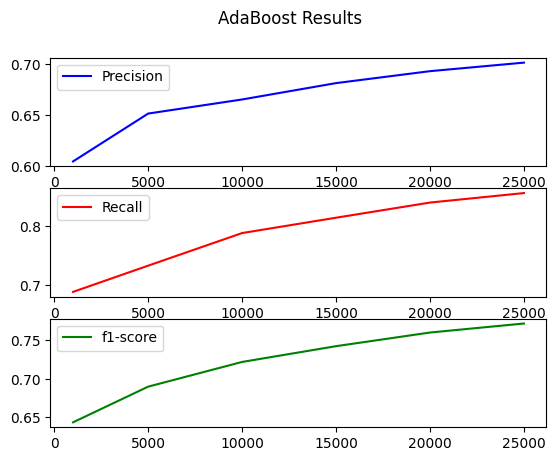


AdaBoost Results:


,Precision,Recall,F1-Score
Training Set Size,,,
1000,0.604797,0.68792,0.643686
5000,0.651540,0.73280,0.689785
10000,0.665294,0.78856,0.721702
15000,0.681271,0.81480,0.742077
20000,0.692932,0.84072,0.759705
25000,0.701277,0.85696,0.771341


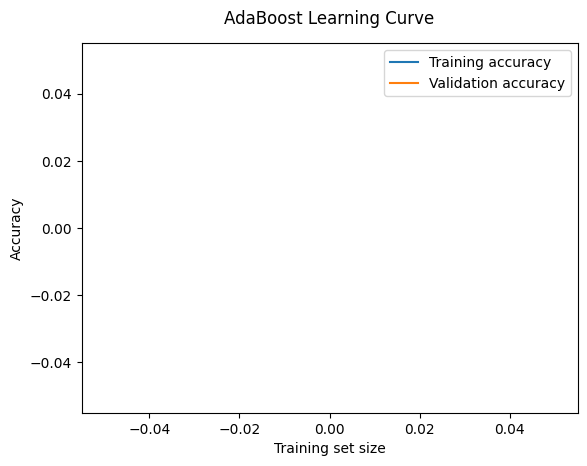


Learning Curve Data:


,Training Accuracy,Validation Accuracy
Training Set Size,,
1000,NaN,NaN
5000,NaN,NaN
10000,NaN,NaN
15000,NaN,NaN
20000,NaN,NaN


In [13]:
AB = AdaBoost()
custom_classification_report(estimator=AB,x_train=x_train,y_train=y_train,x_test=x_test, y_test=y_test, train_sizes = [1000,5000,10000,15000,20000,25000],name='AdaBoost')

### Part 2:
In this Part we are going to compare the algorithms we wrote to the ones from the sci-kit learn library using the same curves as in part one to have a more accurate comparison of the results.

#### Logistic Regression
In this part we will compare our logistic regression algorithm with that of sci-kit learn library.

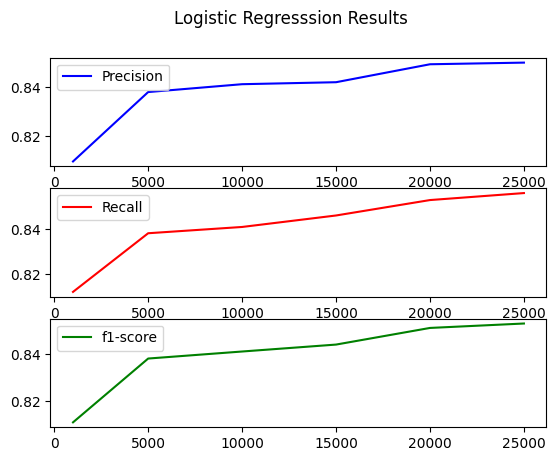

Logistic Regresssion Results:


,Precision,Recall,F1-Score
Training Set Size,,,
1000,0.809554,0.81208,0.810815
5000,0.837838,0.83824,0.838039
10000,0.841040,0.84104,0.841040
15000,0.841850,0.84616,0.843999
20000,0.849168,0.85304,0.851099
25000,0.849837,0.85616,0.852987


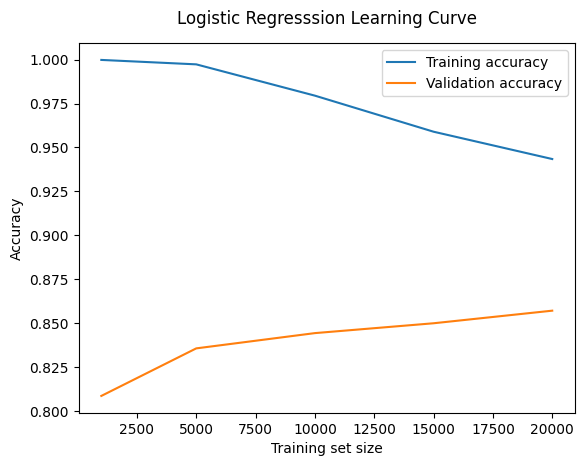


Learning Curve Data:


,Training Accuracy,Validation Accuracy
Training Set Size,,
1000,0.999800,0.80872
5000,0.997280,0.83576
10000,0.979480,0.84444
15000,0.958973,0.85004
20000,0.943440,0.85720


In [40]:
#Ininitialization of the classifiers
our_logistic_regression = LogisticRegression(epochs=100,threshold=0.6, regularization_factor=0.001)
scikit_logistic_regression = skLogReg(max_iter=1000)


# Fit the training data to the classifiers
fit_eval = our_logistic_regression.fit(x_train,y_train)
scikit_logistic_regression.fit(x_train,y_train)

custom_classification_report(estimator=scikit_logistic_regression,x_train=x_train,y_train=y_train,x_test=x_test, y_test=y_test, train_sizes = [1000,5000,10000,15000,20000,25000],name='Logistic Regresssion')

#### Naive Bayes
In this part we will compare our Naive Bayes algorithm with that of sci-kit learn library.

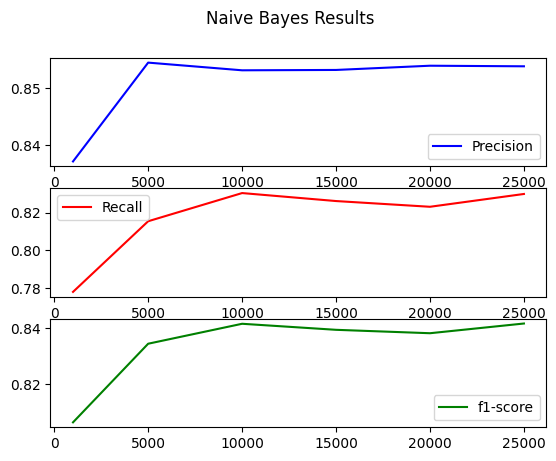

Naive Bayes Results:


,Precision,Recall,F1-Score
Training Set Size,,,
1000,0.837121,0.77792,0.806436
5000,0.854401,0.81544,0.834466
10000,0.853057,0.83040,0.841576
15000,0.853119,0.82616,0.839423
20000,0.853859,0.82312,0.838208
25000,0.853757,0.82992,0.841670


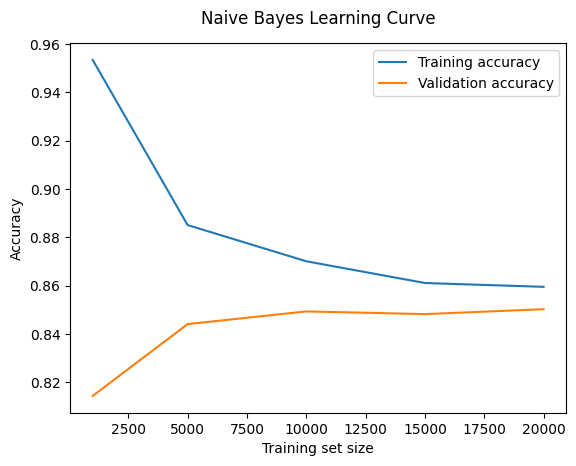


Learning Curve Data:


,Training Accuracy,Validation Accuracy
Training Set Size,,
1000,0.953400,0.81440
5000,0.885080,0.84412
10000,0.870100,0.84936
15000,0.861107,0.84824
20000,0.859530,0.85028


In [41]:
#Classifier initialization
scikit_naive_bayes = BernoulliNB()
our_naive_bayes = NaiveBayes(alpha=0.001)

# Fitting of the training data to the classifiers
scikit_naive_bayes.fit(x_train,y_train)
our_naive_bayes.fit(x_train,y_train)

custom_classification_report(estimator=scikit_naive_bayes,x_train=x_train,y_train=y_train,x_test=x_test, y_test=y_test, train_sizes = [1000,5000,10000,15000,20000,25000],name='Naive Bayes')

#### AdaBoost
In this part we will compare our Naive Bayes algorithm with that of sci-kit learn using the diagrams above 

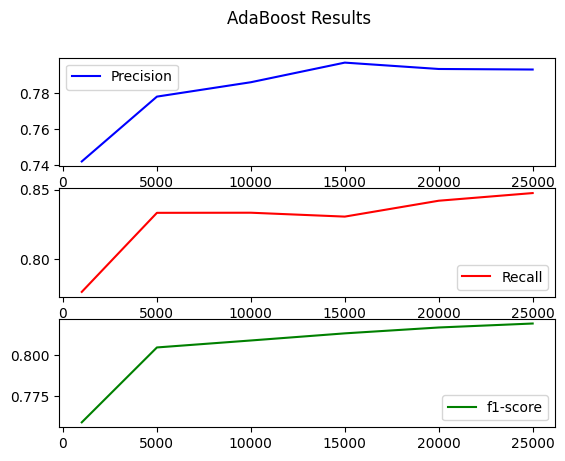

AdaBoost Results:


,Precision,Recall,F1-Score
Training Set Size,,,
1000,0.742103,0.77624,0.758788
5000,0.777877,0.83320,0.804589
10000,0.785817,0.83328,0.808853
15000,0.796639,0.83048,0.813207
20000,0.793127,0.84192,0.816795
25000,0.792830,0.84744,0.819226


In [47]:
# First we initialize the classifiers 
our_adaboost = AdaBoost()
scikit_adaboost = AdaBoostClassifier(n_estimators=70)

# Fit the training data to the classifiers
our_adaboost.fit(x_train, y_train, 70)
scikit_adaboost.fit(x_train, y_train)

custom_classification_report(estimator=scikit_adaboost,x_train=x_train,y_train=y_train,x_test=x_test, y_test=y_test, train_sizes = [1000,5000,10000,15000,20000,25000],name='AdaBoost')

### Part 3:
For this Part we implemment a stacked biGRU RNN with early stopping and L2 regularization 

##### Create Word Embeddings
We tokenize the text data, build a vocabulary and convert the text into sequences of integers in order to be able to give them as inputs to our RNN.

In [52]:
from tqdm import tqdm

train_doc_length = 0
for doc in tqdm(x_train_imdb):
  tokens = str(doc).split()
  train_doc_length += len(tokens)


VOCAB_SIZE = 100000
SEQ_MAX_LENGTH = 250
vectorizer = tf.keras.layers.TextVectorization(max_tokens=VOCAB_SIZE, 
                                               output_mode='int', 
                                               ngrams=1, name='vector_text',
                                               output_sequence_length=SEQ_MAX_LENGTH)
with tf.device('/CPU:0'):
  vectorizer.adapt(x_train_imdb)


100%|██████████| 25000/25000 [00:00<00:00, 27343.34it/s]


##### BiGRU RNN
Our rnn has 5+n layers 
1. input Layer:
the Input layer accepts unvectorized strings.

2. Text Vectorization Layer:
We Vectorize text input into integer sequence

3. Embedding Layer:
We add a word embedding

4. Bidirectional GRU Layers:
n Bidirectional GRU Layers with dropout and l2 regualriZation to prevent overfitting

5. Dropout Layer:
We add a dropout Layer to prevent overfitting.

6. Dense Layer :
We use a dense layer with sigmoid activation function to give the estimated probability of belonging to a specific class

In [53]:
def get_bigru(num_layers=1, emb_size=64, h_size=64):
  inputs = tf.keras.layers.Input(shape=(1,), dtype=tf.string, name='txt_input')
  x = vectorizer(inputs)
  x = tf.keras.layers.Embedding(input_dim=len(vectorizer.get_vocabulary()),
                                output_dim=emb_size, name='word_embeddings',
                                mask_zero=True)(x)
  for n in range(num_layers):
    if n != num_layers - 1:
      x = tf.keras.layers.Bidirectional(tf.keras.layers.GRU(units=h_size, 
                              name=f'bigru_cell_{n}', 
                              return_sequences=True,
                              dropout=0.2,
                              kernel_regularizer=l2(0.0001)))(x)
    else:
      x = tf.keras.layers.Bidirectional(tf.keras.layers.GRU(units=h_size, 
                                        name=f'bigru_cell_{n}',
                                        dropout=0.2,
                                        kernel_regularizer=l2(0.0001)))(x)

  x = tf.keras.layers.Dropout(rate=0.5)(x)
  o = tf.keras.layers.Dense(units=1, activation='sigmoid', name='lr')(x)

  early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

  return tf.keras.models.Model(inputs=inputs, outputs=o, name='biGRU_RNN'), early_stopping




In [55]:
bigru_rnn, early_stopping = get_bigru(num_layers=2)
print(bigru_rnn.summary())

Model: "biGRU_RNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 txt_input (InputLayer)      [(None, 1)]               0         
                                                                 
 vector_text (TextVectoriza  (None, 250)               0         
 tion)                                                           
                                                                 
 word_embeddings (Embedding  (None, 250, 64)           5139904   
 )                                                               
                                                                 
 bidirectional_27 (Bidirect  (None, 250, 128)          49920     
 ional)                                                          
                                                                 
 bidirectional_28 (Bidirect  (None, 128)               74496     
 ional)                                                  

In [56]:
bigru_rnn.compile(loss=tf.keras.losses.BinaryCrossentropy(), 
                   optimizer=tf.keras.optimizers.Adam(),
                   metrics=['binary_accuracy'])

history = bigru_rnn.fit(x=x_train_imdb, y=y_train,
               epochs=5, verbose=1, batch_size=64, validation_split= 0.2 ,callbacks = [early_stopping])

Epoch 1/5
313/313 [==============================] - 226s 694ms/step - loss: 0.4838 - binary_accuracy: 0.7555 - val_loss: 0.3128 - val_binary_accuracy: 0.8756
Epoch 2/5
313/313 [==============================] - 210s 672ms/step - loss: 0.1975 - binary_accuracy: 0.9297 - val_loss: 0.3205 - val_binary_accuracy: 0.8754
Epoch 3/5
313/313 [==============================] - 215s 686ms/step - loss: 0.0826 - binary_accuracy: 0.9755 - val_loss: 0.4450 - val_binary_accuracy: 0.8628
Epoch 4/5
313/313 [==============================] - 213s 681ms/step - loss: 0.0378 - binary_accuracy: 0.9908 - val_loss: 0.5734 - val_binary_accuracy: 0.8652


In [57]:
# print(bigru_rnn.evaluate(x_test_imdb, y_test))
y_pred = (bigru_rnn.predict(x_test_imdb) > 0.5).astype("int32")
print(classification_report(y_pred,y_test))

782/782 [==============================] - 79s 98ms/step
              precision    recall  f1-score   support

           0       0.86      0.87      0.86     12401
           1       0.87      0.86      0.86     12599

    accuracy                           0.86     25000
   macro avg       0.86      0.86      0.86     25000
weighted avg       0.86      0.86      0.86     25000



##### Diagrams
We make a mlp learning curve, a loss plot function and a precision recall to plot out the data needed

In [49]:
def mlp_learning_curve(x_train, y_train, train_sizes):
    training_acc = []
    val_acc = []
    early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
    for size in train_sizes:
        model, early_stopping = get_bigru(num_layers=2)
        model.compile(loss=tf.keras.losses.BinaryCrossentropy(), 
                   optimizer=tf.keras.optimizers.Adam(),
                   metrics=['binary_accuracy'])

        learning_history = model.fit(x=x_train[:size], y=y_train[:size], epochs=10, verbose=1, batch_size=64, validation_split=0.2,callbacks = [early_stopping])
        max_train_accuracy_reached = learning_history.history['binary_accuracy'][-1]
        max_val_accuracy_reached = learning_history.history['val_binary_accuracy'][-1]

        training_acc.append(max_train_accuracy_reached)
        val_acc.append(max_val_accuracy_reached)
    plt.plot(train_sizes,training_acc,label='Training Accuracy')
    plt.plot(train_sizes, val_acc,label='Validation Accuracy')
    plt.title('Learning Curve')
    plt.xlabel('Train Sizes')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

def loss_plot(history):
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlim(0,5)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Loss')
    plt.show()
    loss_df = pd.DataFrame({'Epoch': range(1, len(history.history['loss']) + 1),
                         'Training Loss': history.history['loss'],
                         'Validation Loss': history.history['val_loss']})
    print(loss_df)

##### Precision Recall Curve


782/782 [==============================] - 14s 16ms/step


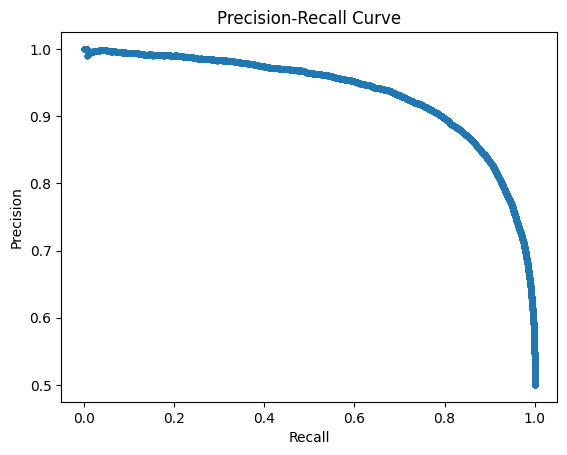

In [29]:
# Evaluate the model
test_loss, test_acc = bigru_rnn.evaluate(x_test_imdb, y_test)

# Predict probabilities on the test set
y_probs = bigru_rnn.predict(x_test_imdb)

# Compute precision and recall
precision, recall, _ = precision_recall_curve(y_test, y_probs)



# Plot the precision-recall curve
plt.plot(recall, precision, marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()



##### Learning curve 


Epoch 1/10
13/13 [==============================] - 23s 1s/step - loss: 0.7397 - binary_accuracy: 0.5013 - val_loss: 0.7335 - val_binary_accuracy: 0.5050
Epoch 2/10
13/13 [==============================] - 13s 984ms/step - loss: 0.7251 - binary_accuracy: 0.6288 - val_loss: 0.7206 - val_binary_accuracy: 0.5800
Epoch 3/10
13/13 [==============================] - 13s 975ms/step - loss: 0.6880 - binary_accuracy: 0.7950 - val_loss: 0.6940 - val_binary_accuracy: 0.6350
Epoch 4/10
13/13 [==============================] - 13s 982ms/step - loss: 0.4355 - binary_accuracy: 0.9075 - val_loss: 0.6636 - val_binary_accuracy: 0.7100
Epoch 5/10
13/13 [==============================] - 12s 962ms/step - loss: 0.1101 - binary_accuracy: 0.9712 - val_loss: 0.8219 - val_binary_accuracy: 0.6750
Epoch 6/10
13/13 [==============================] - 13s 968ms/step - loss: 0.0395 - binary_accuracy: 0.9962 - val_loss: 1.0989 - val_binary_accuracy: 0.6850
Epoch 7/10
13/13 [==============================] - 12s 962ms

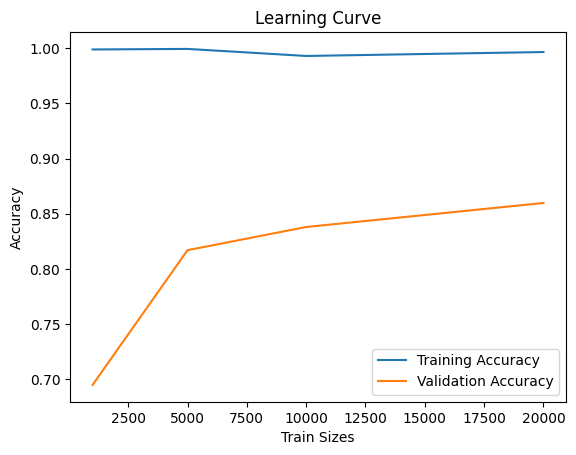

In [45]:
mlp_learning_curve( x_train = x_train_imdb, y_train = y_train, train_sizes = [1000,5000,10000,20000])

##### Loss Plot


Epoch 1/5
313/313 [==============================] - 339s 1s/step - loss: 0.4747 - binary_accuracy: 0.7603 - val_loss: 0.3064 - val_binary_accuracy: 0.8762
Epoch 2/5
313/313 [==============================] - 307s 980ms/step - loss: 0.1825 - binary_accuracy: 0.9373 - val_loss: 0.3403 - val_binary_accuracy: 0.8794
Epoch 3/5
313/313 [==============================] - 308s 984ms/step - loss: 0.0754 - binary_accuracy: 0.9771 - val_loss: 0.4617 - val_binary_accuracy: 0.8694
Epoch 4/5
313/313 [==============================] - 308s 984ms/step - loss: 0.0334 - binary_accuracy: 0.9923 - val_loss: 0.7810 - val_binary_accuracy: 0.8642


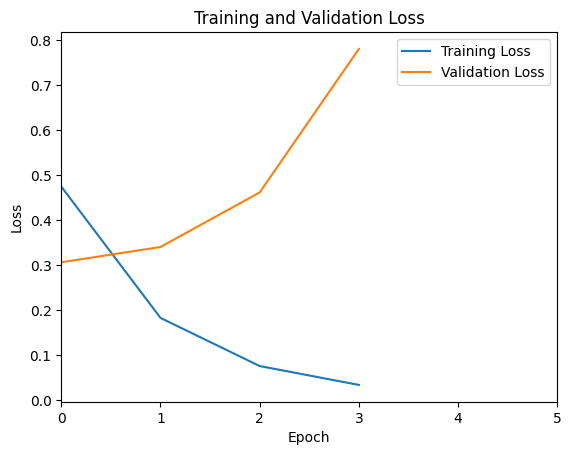

   Epoch  Training Loss  Validation Loss
0      1       0.474659         0.306365
1      2       0.182539         0.340259
2      3       0.075356         0.461681
3      4       0.033372         0.781028


In [51]:
bigru_rnn1,early_stopping=get_bigru(num_layers=2)
bigru_rnn1.compile(loss=tf.keras.losses.BinaryCrossentropy(), 
                   optimizer=tf.keras.optimizers.Adam(),
                   metrics=['binary_accuracy'])
history = bigru_rnn1.fit(x=x_train_imdb, y=y_train,
               epochs=5, verbose=1, batch_size=64, validation_split=0.2,callbacks = [early_stopping])
loss_plot(history)